In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import log_loss


In [2]:
df = pd.read_csv("./task_2022/train_data_swc.csv")

In [3]:
target = "y"

# Feature Creation

In [4]:
# Config
top_n_features = 4 # 2n+n*(n-1) features at the final
# 5 -> 30
# 10 -> 110
# O(n^2)

In [5]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from itertools import combinations
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)

from sklearn.feature_selection import VarianceThreshold
# Create VarianceThreshold object with a variance with a threshold of 0.1
var_thresh = VarianceThreshold(threshold=0.1)
# Fit the object to our data
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

# Get the names of the remaining columns
feature_names = X_train.columns[var_thresh.get_support(indices=True)]

# Convert back to DataFrame and assign column names
X_train_var = pd.DataFrame(X_train_var, columns=feature_names)
X_test_var = pd.DataFrame(X_test_var, columns=feature_names)

# Fit a LGBM model to find important features
lgbm = LGBMClassifier(objective='multiclass', num_class=9)
lgbm.fit(X_train_var, y_train)

# Get feature importances
importances = lgbm.feature_importances_

In [6]:
# Get the top 10 most important feature names
top_features = X_train_var.columns[importances.argsort()[-top_n_features:]]

In [7]:
# Use only the top 10 important features for the new feature creation
X_train_imp = X_train[top_features].copy()
X_test_imp = X_test[top_features].copy()

In [8]:
# Create the new features on both train and test set
datasets = {'train': X_train_imp, 'test': X_test_imp}
min_val = min(X_train_imp.min().min(), X_test_imp.min().min())
max_val = max(X_train_imp.max().max(), X_test_imp.max().max())
bin_edges = np.linspace(min_val, max_val, num=6)

for name in datasets:
    # Interaction terms
    interactions = pd.DataFrame(index=datasets[name].index)
    for col1, col2 in combinations(datasets[name].columns, 2):
        interactions[col1+'_times_'+col2] = datasets[name][col1] * datasets[name][col2]

    # Binning
    X_binned = pd.DataFrame(index=datasets[name].index)
    for col in datasets[name].columns:
        X_binned[col + '_binned'] = pd.cut(datasets[name][col], bins=bin_edges, labels=False, include_lowest=True)

    
    # Ratios
    ratios = pd.DataFrame(index=datasets[name].index)
    for col1, col2 in combinations(datasets[name].columns, 2):
        ratios[col1+'_to_'+col2] = datasets[name][col1] / datasets[name][col2]
    # Replace inf and NaN values in ratios
    ratios = ratios.replace([np.inf, -np.inf], np.nan)
    ratios.fillna(-1, inplace=True)
    datasets[name] = datasets[name].join(interactions).join(X_binned).join( ratios)


# Remove original features
for name in datasets:
    datasets[name].drop(top_features, axis=1, inplace=True)

# Assign back the modified dataframes
X_train_imp, X_test_imp = datasets['train'], datasets['test']

In [9]:
from umap import UMAP

# Fit a UMAP model
umap = UMAP(n_components=10)  # You can choose the number of components
X_train_umap = umap.fit_transform(X_train)
X_test_umap = umap.transform(X_test)

# Convert to DataFrame
X_train_umap = pd.DataFrame(X_train_umap, columns=[f'umap_{i}' for i in range(1, 11)])
X_test_umap = pd.DataFrame(X_test_umap, columns=[f'umap_{i}' for i in range(1, 11)])

/home/serhat/Documents/cases/science_wave_task/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/serhat/Documents/cases/science_wave_task/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/serhat/Documents/cases/scien

In [10]:
# For the training data
X_train.reset_index(drop=True, inplace=True)
X_train_imp.reset_index(drop=True, inplace=True)
X_train_umap.reset_index(drop=True, inplace=True)

X_train_combined = pd.concat([X_train, X_train_imp, X_train_umap], axis=1)

# For the testing data
X_test.reset_index(drop=True, inplace=True)
X_test_imp.reset_index(drop=True, inplace=True)
X_test_umap.reset_index(drop=True, inplace=True)

X_test_combined = pd.concat([X_test, X_test_imp, X_test_umap], axis=1)

# Feature Selection

In [11]:
def drop_highly_correlated_features(df, threshold=0.95):
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop features 
    df.drop(to_drop, axis=1, inplace=True)
    
    print(f"Dropped {len(to_drop)} columns.")
    
    return df

# Apply the function to your combined datasets
X_train_combined = drop_highly_correlated_features(X_train_combined)
X_test_combined = X_test_combined[X_train_combined.columns]  # Keep only the remaining columns in the test set

Dropped 3 columns.


In [19]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier

selector = RFECV(LGBMClassifier(), step=10, cv=5, scoring='neg_log_loss', verbose=1)  # Example step and cv
df = selector.fit_transform(X_train_combined, y_train)

Fitting estimator with 131 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fitting estimator with 81 features.
Fitting estimator with 71 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 21 features.
Fitting estimator with 11 features.
Fitting estimator with 131 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fitting estimator with 81 features.
Fitting estimator with 71 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 21 features.
Fitting estimator with 11 features.
Fitting estimator with 131 features.
Fitting estimator w

In [26]:
X_test_transformed = selector.transform(X_test_combined)

# Model Training

In [12]:
train = X_train_combined
test = X_test_combined

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Define the base models
level0 = list()
level0.append(('nn', MLPClassifier(max_iter=1000, verbose = True)))
level0.append(('lgbm', LGBMClassifier( verbose = 1)))
level0.append(('svm', SVC(probability=True, verbose = True)))

# Define meta learner model
level1 = DecisionTreeClassifier()

# Define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2, n_jobs = -1)

# Implementing early stopping manually
model.fit(train, y_train)

*
optimization finished, #iter = 567
obj = -590.110638, rho = -0.402465
nSV = 781, nBSV = 720
Total nSV = 781
*
optimization finished, #iter = 528
obj = -600.121032, rho = -0.385955
nSV = 778, nBSV = 728
Total nSV = 778
*
optimization finished, #iter = 537
obj = -603.572417, rho = -0.432222
nSV = 780, nBSV = 730
Total nSV = 780
*
optimization finished, #iter = 542
obj = -587.812100, rho = -0.499772
nSV = 769, nBSV = 721
Total nSV = 769
*
optimization finished, #iter = 541
obj = -597.454866, rho = -0.459225
nSV = 772, nBSV = 721
Total nSV = 772
*
optimization finished, #iter = 673
obj = -707.143935, rho = 0.412013
nSV = 907, nBSV = 849
*
optimization finished, #iter = 482
obj = -431.666618, rho = -0.175695
nSV = 569, nBSV = 523
Total nSV = 569
*
optimization finished, #iter = 475
obj = -435.553794, rho = -0.266499
nSV = 583, nBSV = 529
Total nSV = 583
*
optimization finished, #iter = 480
obj = -428.290492, rho = -0.270189
nSV = 571, nBSV = 518
Total nSV = 571
*
optimization finished, #i

StackingClassifier(cv=2,
                   estimators=[('nn',
                                MLPClassifier(max_iter=1000, verbose=True)),
                               ('lgbm', LGBMClassifier(verbose=1)),
                               ('svm', SVC(probability=True, verbose=True))],
                   final_estimator=DecisionTreeClassifier(), n_jobs=-1)

# Evaluation

In [18]:
y_pred_proba

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(test)
y_pred_proba = model.predict_proba(test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {class_report}')

[LibSVM][LibSVM]Accuracy: 0.724
Log Loss: 9.948048335396338
Confusion Matrix:
 [[ 172   18    4    2    1   31   20   48   70]
 [  20 2230  663  159   12   22   51   19   15]
 [   8  669  752  106    2   16   63    6    6]
 [   2  160  104  284    2   12   16    1    3]
 [   1    8    4    9  521    3    7    1   11]
 [  52   21   11   30    0 2600   65   64   61]
 [  29   51   55   19    3   73  324   24    7]
 [  90   28   11    4    3   82   28 1382   54]
 [  86   16    6    3    1   50    7   41  785]]
Classification Report:
               precision    recall  f1-score   support

           1       0.37      0.47      0.42       366
           2       0.70      0.70      0.70      3191
           3       0.47      0.46      0.46      1628
           4       0.46      0.49      0.47       584
           5       0.96      0.92      0.94       565
           6       0.90      0.90      0.90      2904
           7       0.56      0.55      0.56       585
           8       0.87      0.

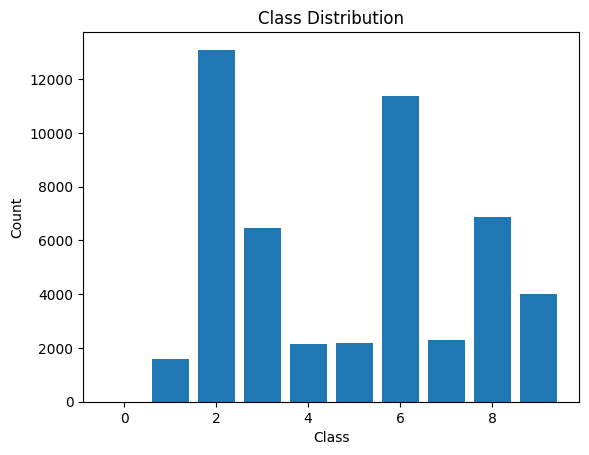

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train is a NumPy array containing label-encoded classes

# Calculate class distribution
class_counts = np.bincount(y_train)

# Plot class distribution
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()
